# Phenotyping Pipeline SIFIBR

# 0. Импортируем библиотеки и загружаем данные

In [1]:
import numpy as np
import cv2
import os
import json
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [ ]:
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [107]:
analysis_date = '2025_28_06_12_00'

# 1. Баланс белого

In [108]:
args = WorkflowInputs(
    images=[f"./sifibr/IMG_{analysis_date}.jpg"],
    names="image1",
    result="sifibr_analysis_results.json",
    outdir=".",
    writeimg=False,
    debug="plot")

In [109]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

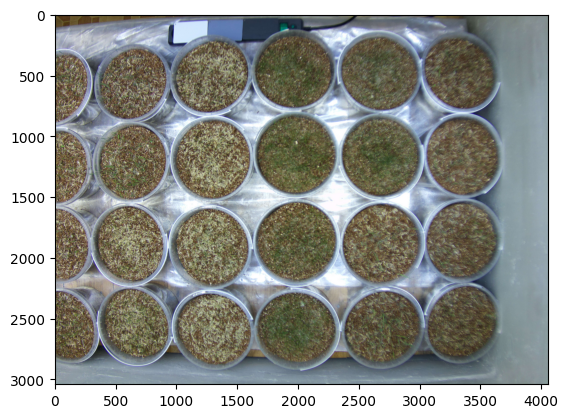

In [110]:
img, path, filename = pcv.readimage(filename=args.image1)

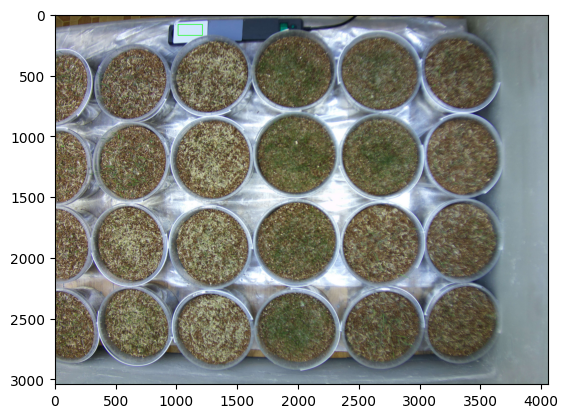

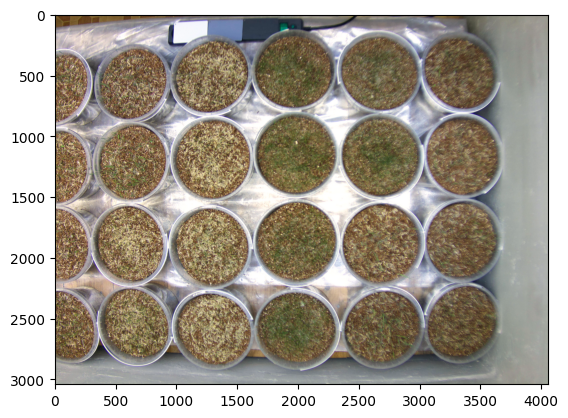

In [111]:
# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"

# Corrects image based on color standard and stores output as corrected_img
corrected_img = pcv.white_balance(img=img, mode='hist', roi=[1010, 85, 200, 90])

In [112]:
resized_img = cv2.resize(corrected_img, (0, 0), fx=0.25, fy=0.25)
cropped_img = resized_img[25:, 70:950] 
blurred = cv2.bilateralFilter(cropped_img,9,150,150)

In [113]:
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# Диапазон коричневого цвета — может потребоваться подгонка
# lower_brown = np.array([18, 31, 93])
# upper_brown = np.array([22, 255, 149])

lower_brown = np.array([0, 80, 0])
upper_brown = np.array([30, 150, 230])

mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

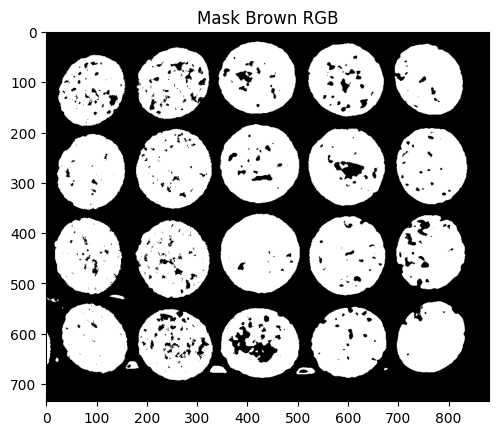

In [114]:
plt.imshow(cv2.cvtColor(mask_brown, cv2.COLOR_RGB2BGR))
plt.title('Mask Brown RGB')
plt.show()

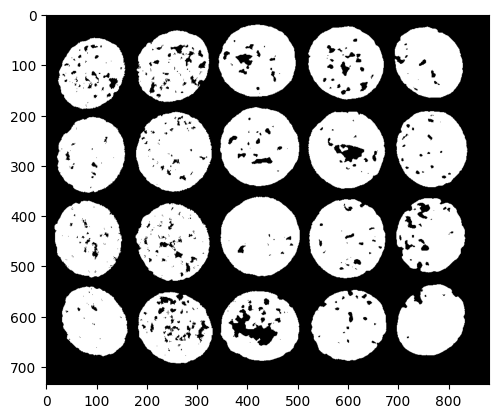

In [115]:
fill_mask = pcv.fill(bin_img=mask_brown, size=1000)

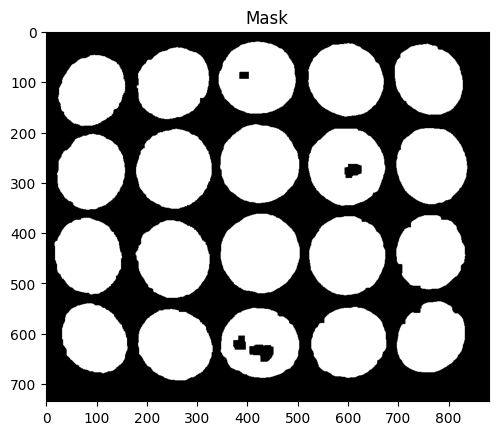

In [116]:
kernel = np.ones((13, 13), np.uint8)
closed_mask = cv2.morphologyEx(fill_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(cv2.cvtColor(closed_mask, cv2.COLOR_RGB2BGR))
plt.title('Mask')
plt.show()

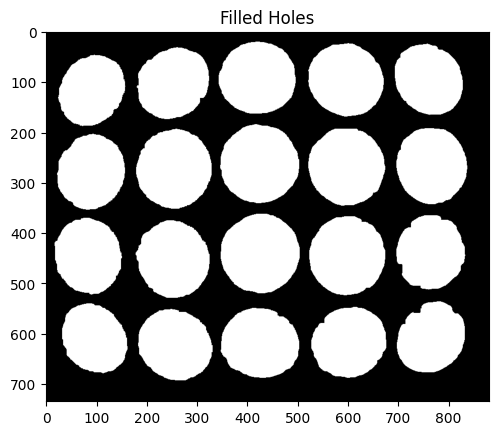

In [117]:
# Копируем маску и создаем холст
im_floodfill = closed_mask.copy()
h, w = closed_mask.shape[:2]
mask_flood = np.zeros((h+2, w+2), np.uint8)

# Заливаем фон (0,0) как внешний фон
cv2.floodFill(im_floodfill, mask_flood, (0, 0), 255)

# Инвертируем залитое, чтобы получить только дыры
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Объединяем оригинальную маску и инвертированную заливку
filled_mask = closed_mask | im_floodfill_inv

plt.imshow(cv2.cvtColor(filled_mask, cv2.COLOR_RGB2BGR))
plt.title('Filled Holes')
plt.show()

In [118]:
# Убедись, что маска — одноцветная (grayscale)
if len(filled_mask.shape) == 3:
    filled_mask = cv2.cvtColor(filled_mask, cv2.COLOR_BGR2GRAY)

# Применяем маску: оставляем только ту часть изображения, где маска = белая (255)
mask_pots = cv2.bitwise_and(cropped_img, cropped_img, mask=filled_mask)

cv2.imshow("Result", mask_pots)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [119]:
# Найдём контуры
contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Вычисляем центры всех контуров
centers = []
for i, cnt in enumerate(contours):
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((i, cX, cY))  # сохраняем индекс и координаты
    else:
        centers.append((i, cnt[0][0][0], cnt[0][0][1]))

# Сортируем: сначала по Y (строки), потом по X (внутри строки)
# Используем "кластеризацию по строкам" по Y
def sort_grid_like(centers, row_tolerance=20):
    # Сначала отсортируем по Y (строки)
    centers = sorted(centers, key=lambda x: x[2])
    rows = []
    current_row = []

    for c in centers:
        if not current_row:
            current_row.append(c)
        else:
            # Если Y примерно такой же — та же строка
            if abs(c[2] - current_row[-1][2]) < row_tolerance:
                current_row.append(c)
            else:
                # Сортируем строку по X и добавляем
                rows.append(sorted(current_row, key=lambda x: x[1]))
                current_row = [c]
    if current_row:
        rows.append(sorted(current_row, key=lambda x: x[1]))

    # Разворачиваем в общий список
    sorted_indices = [i for row in rows for (i, _, _) in row]
    return sorted_indices

# Получаем индексы контуров в правильном порядке
ordered_indices = sort_grid_like(centers)

# Копия изображения
contour_img = cropped_img.copy()

# Рисуем контуры и правильные номера
for label, idx in enumerate(ordered_indices):
    cnt = contours[idx]
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = cnt[0][0]

    cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(contour_img, str(label + 1), (cX, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# Показать
cv2.imshow("Labeled Pots", contour_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [120]:
output_dir = os.path.join(".", analysis_date)
os.makedirs(output_dir, exist_ok=True)
output_pots_dir = output_dir + "/pots/"
output_hists_dir = output_dir + "/hists/"
output_data_dir = output_dir + "/data/"

os.makedirs(output_pots_dir, exist_ok=True)
os.makedirs(output_hists_dir, exist_ok=True)
os.makedirs(output_data_dir, exist_ok=True)

In [121]:
cv2.imwrite(os.path.join(output_dir, 'contours_pots.png'), contour_img)
cv2.imwrite(os.path.join(output_dir, 'mask_pots.png'), mask_pots)
cv2.imwrite(os.path.join(output_dir, 'preprocessed.jpg'), cropped_img)

True

In [122]:
pcv.params.debug = "none"

for label, idx in enumerate(ordered_indices):
    if label in [0, 5]:
        continue

    cnt = contours[idx]
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_pot = cropped_img[y:y+h, x:x+w]

    # Маска для объекта
    mask = np.zeros((h, w), dtype=np.uint8)
    cnt_shifted = cnt - [x, y]
    cv2.drawContours(mask, [cnt_shifted], -1, 255, -1)

    # Сохраняем PNG с альфа-каналом (прозрачностью)
    cropped_pot_rgba = cv2.cvtColor(cropped_pot, cv2.COLOR_BGR2BGRA)
    cropped_pot_rgba[:, :, 3] = mask

    pot_filename = os.path.join(output_pots_dir, f"pot_{label + 1}.png")
    cv2.imwrite(pot_filename, cropped_pot_rgba)

    # ---------- Гистограмма цвета ----------
    rgb_img = cv2.cvtColor(cropped_pot, cv2.COLOR_BGR2RGB)

    pcv.outputs.clear()
    pcv.analyze.color(rgb_img=rgb_img, labeled_mask=mask, n_labels=1, colorspaces='hsv')
    json_path = os.path.join(output_data_dir, f"pot_{label+1}_color.json")
    pcv.outputs.save_results(filename=json_path)
    
    chart = pcv.visualize.histogram(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV), mask, bins=25)
    
    hist_filename = os.path.join(output_hists_dir, f"pot_{label + 1}_color_hist.png")
    chart.save(hist_filename)  # Altair Chart method

# 2. Формирование даннных

In [123]:
#Обрати внимание на время
analysis_date

'2025_28_06_12_00'

In [124]:
def extract_color_statistics_from_image(image_path, plant_id=None, day=None):
    # Загрузить изображение с помощью OpenCV
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение {image_path}")

    # Конвертировать BGR в HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Разделить каналы
    h_channel = hsv_img[:, :, 0]  # Hue: 0-179 в OpenCV
    s_channel = hsv_img[:, :, 1]  # Saturation: 0-255
    v_channel = hsv_img[:, :, 2]  # Value: 0-255

    # Нормализовать каналы для удобства:
    hue_vals = h_channel.flatten() * 2  # Hue: 0-360 (умножаем на 2)
    sat_vals = s_channel.flatten() / 255.0  # Saturation 0-1
    val_vals = v_channel.flatten() / 255.0  # Value 0-1

    # Рассчитать статистики
    stats = {
        "plant_id": plant_id,
        "hue_mean": np.mean(hue_vals),
        "hue_std": np.std(hue_vals),
        "hue_min": np.min(hue_vals),
        "hue_max": np.max(hue_vals),
        "hue_p25": np.percentile(hue_vals, 25),
        "hue_p50": np.percentile(hue_vals, 50),
        "hue_p75": np.percentile(hue_vals, 75),
        "hue_range": np.max(hue_vals) - np.min(hue_vals),

        "saturation_mean": np.mean(sat_vals),
        "saturation_std": np.std(sat_vals),
        "saturation_min": np.min(sat_vals),
        "saturation_max": np.max(sat_vals),
        "saturation_p25": np.percentile(sat_vals, 25),
        "saturation_p50": np.percentile(sat_vals, 50),
        "saturation_p75": np.percentile(sat_vals, 75),
        "saturation_range": np.max(sat_vals) - np.min(sat_vals),

        "value_mean": np.mean(val_vals),
        "value_std": np.std(val_vals),
        "value_min": np.min(val_vals),
        "value_max": np.max(val_vals),
        "value_p25": np.percentile(val_vals, 25),
        "value_p50": np.percentile(val_vals, 50),
        "value_p75": np.percentile(val_vals, 75),
        "value_range": np.max(val_vals) - np.min(val_vals),

        "hue_skew": scipy.stats.skew(hue_vals),
        "saturation_skew": scipy.stats.skew(sat_vals),
        "value_skew": scipy.stats.skew(val_vals),

        "hue_kurtosis": scipy.stats.kurtosis(hue_vals),
        "saturation_kurtosis": scipy.stats.kurtosis(sat_vals),
        "value_kurtosis": scipy.stats.kurtosis(val_vals),

        "k": 1 if plant_id in [5, 10, 14, 15, 19, 20] else 0,
        "sh": 1 if plant_id in [3, 4, 8, 9, 13, 18] else 0,

        "irk": 1 if plant_id in [4, 9, 12, 15, 17, 20] else 0,
        "b2": 1 if plant_id in [2, 5, 7, 10, 13, 18] else 0,
    }

    if day is not None:
        stats["days_gone"] = day - 17

    # Округляем для удобства
    for k, v in stats.items():
        if isinstance(v, (float, np.floating)):
            stats[k] = round(v, 2)

    return stats

In [125]:
import csv

csv_filename = "stats_output.csv"

# Чтобы записать заголовок один раз, возьмем поле из первого файла
first_file = False

for filename in os.listdir(output_pots_dir):
    plant_id = int(filename.split('_')[1].split('.')[0])
    day = int(output_data_dir.split('_')[1])

    stats = extract_color_statistics_from_image(output_pots_dir + filename, plant_id, day)
    
    # Записываем в CSV
    with open(csv_filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=stats.keys())
        if first_file:
            writer.writeheader()  # пишем заголовок только один раз
            first_file = False
        writer.writerow(stats)
    

# 3. Анализ данных

In [128]:
df = pd.read_csv('C:/VsCodeProjects/ML/PlantsCV/' + csv_filename)

In [129]:
df

,plant_id,hue_mean,hue_std,hue_min,hue_max,hue_p25,hue_p50,hue_p75,hue_range,saturation_mean,...,saturation_skew,value_skew,hue_kurtosis,saturation_kurtosis,value_kurtosis,k,sh,irk,b2,days_gone
0,10,53.78,59.41,0,254,26.0,34.0,42.0,254,0.36,...,-1.10,0.89,3.79,0.20,1.04,1,0,0,1,9
1,11,39.05,33.43,0,254,26.0,34.0,42.0,254,0.36,...,-0.39,0.13,22.98,-0.46,-0.70,0,0,0,0,9
2,12,46.47,43.60,0,254,30.0,38.0,46.0,254,0.33,...,-0.51,0.24,11.65,-0.67,-0.67,0,0,1,0,9
3,13,43.78,36.10,0,254,30.0,38.0,46.0,254,0.38,...,-0.92,1.19,16.82,-0.40,0.54,0,1,0,1,9
4,14,45.20,45.04,0,254,26.0,34.0,44.0,254,0.36,...,-0.90,0.98,10.88,-0.33,0.57,1,0,0,0,9
5,15,55.04,57.73,0,254,28.0,36.0,46.0,254,0.35,...,-0.84,1.36,3.62,-0.22,2.20,1,0,1,0,9
6,16,46.90,43.98,0,254,28.0,38.0,46.0,254,0.36,...,-0.49,0.27,11.62,-0.22,-0.39,0,0,0,0,9
7,17,51.87,50.56,0,254,28.0,38.0,48.0,254,0.33,...,-0.50,0.33,6.40,-0.53,-0.29,0,0,1,0,9
8,18,49.38,38.15,0,254,32.0,42.0,50.0,254,0.37,...,-0.93,1.21,12.87,0.02,1.81,0,1,0,1,9
9,19,48.03,44.93,0,254,28.0,36.0,46.0,254,0.38,...,-0.93,1.15,9.26,-0.12,1.68,1,0,0,0,9


In [133]:
pot_3_df = df[df['plant_id'] == 3]

In [134]:
pot_3_df

,plant_id,hue_mean,hue_std,hue_min,hue_max,hue_p25,hue_p50,hue_p75,hue_range,saturation_mean,...,saturation_skew,value_skew,hue_kurtosis,saturation_kurtosis,value_kurtosis,k,sh,irk,b2,days_gone
12,3,49.65,44.38,0,254,32.0,40.0,48.0,254,0.38,...,-1.03,1.73,10.42,0.00,3.20,0,1,0,0,9
30,3,55.35,50.12,0,254,34.0,42.0,52.0,254,0.37,...,-1.00,1.87,6.85,0.01,3.66,0,1,0,0,10
48,3,54.86,45.68,0,254,34.0,44.0,56.0,254,0.38,...,-1.08,1.91,8.80,0.14,3.83,0,1,0,0,11


In [136]:
pot_3_df['saturation_p50']

12    0.44
30    0.41
48    0.42
Name: saturation_p50, dtype: float64

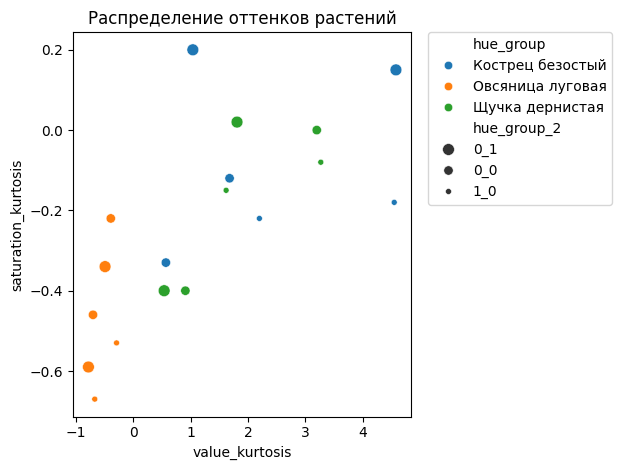

In [64]:
df['hue_group'] = df['k'].astype(str) + '_' + df['sh'].astype(str)
df['hue_group_2'] = df['irk'].astype(str) + '_' + df['b2'].astype(str)

# Словарь с подписями
label_map = {
    '0_0': 'Овсяница луговая',
    '0_1': 'Щучка дернистая',
    '1_0': 'Кострец безостый',
}

# Строим график
plot = sns.scatterplot(
    x='value_kurtosis',
    y='saturation_kurtosis',
    data=df,
    hue='hue_group',
    palette='tab10',
    size='hue_group_2'
)

plt.xlabel('value_kurtosis')
plt.ylabel('saturation_kurtosis')
plt.title('Распределение оттенков растений')

# Заменим метки легенды
handles, labels = plot.get_legend_handles_labels()

# Разделим метки: первые N — hue, остальные — size
# Найдём где заканчивается hue_group по названиям
split_idx = next(i for i, label in enumerate(labels) if label not in label_map and i != 0)

# Новые метки (с русскими названиями)
new_labels = [labels[0]] + [label_map.get(l, l) for l in labels[1:split_idx]] + labels[split_idx:]
new_handles = handles

# Выводим легенду сбоку
plt.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


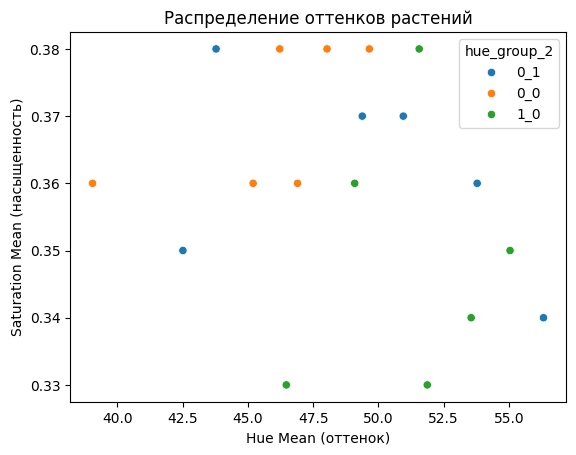

In [137]:
df['hue_group_2'] = df['irk'].astype(str) + '_' + df['b2'].astype(str)

# k = 0, sh = 1, то → hue_group = "0_1"
# k = 1, sh = 0, то → hue_group = "1_0"
# k = 0, sh = 0, то → hue_group = "0_0"

sns.scatterplot(x='hue_mean', y='saturation_mean', data=df, hue='hue_group_2', palette='tab10')

plt.xlabel('Hue Mean (оттенок)')
plt.ylabel('Saturation Mean (насыщенность)')
plt.title('Распределение оттенков растений')
plt.show()

In [30]:
pot = cv2.imread(output_pots_dir + 'pot_7.png')

In [32]:
pot_hsv = cv2.cvtColor(pot, cv2.COLOR_BGR2HSV)

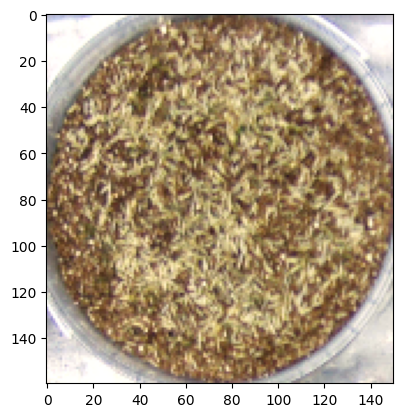

In [34]:
plt.imshow(cv2.cvtColor(pot_hsv, cv2.COLOR_HSV2RGB))
plt.show()

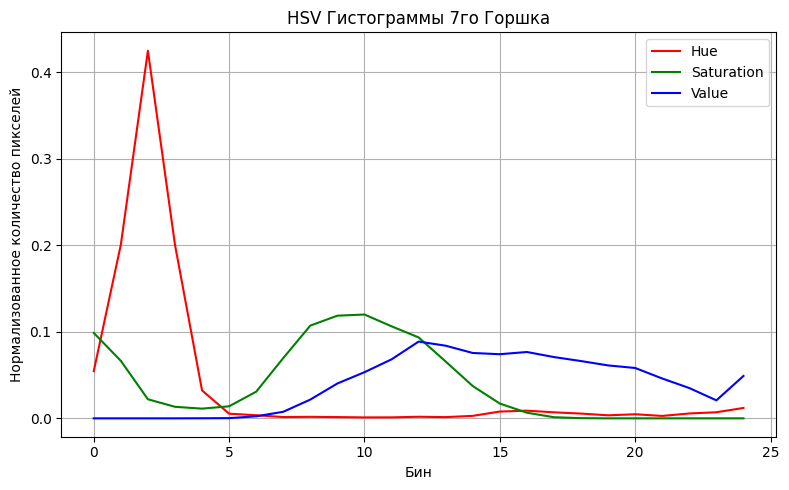

In [58]:
h, s, v = cv2.split(pot_hsv)

# Параметры
bins = 25

# Вычисление гистограмм
hist_h = cv2.calcHist([h], [0], None, [bins], [0, 180])
hist_s = cv2.calcHist([s], [0], None, [bins], [0, 256])
hist_v = cv2.calcHist([v], [0], None, [bins], [0, 256])

# Нормализация гистограмм для совместимого отображения
hist_h = hist_h / hist_h.sum()
hist_s = hist_s / hist_s.sum()
hist_v = hist_v / hist_v.sum()

# Построение общего графика
plt.figure(figsize=(8, 5))
plt.plot(hist_h, color='r', label='Hue')
plt.plot(hist_s, color='g', label='Saturation')
plt.plot(hist_v, color='b', label='Value')

plt.title('HSV Гистограммы 7го Горшка')
plt.xlabel('Бин')
plt.ylabel('Нормализованное количество пикселей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
h, s, v = cv2.split(pot_hsv)

# Словарь для хранения статистики
stats = {
    'Hue':   {'mean': np.mean(h), 'std': np.std(h), 'min': np.min(h), 'max': np.max(h)},
    'Sat':   {'mean': np.mean(s), 'std': np.std(s), 'min': np.min(s), 'max': np.max(s)},
    'Value': {'mean': np.mean(v), 'std': np.std(v), 'min': np.min(v), 'max': np.max(v)},
}

# Печать результатов
for channel, values in stats.items():
    print(f"{channel}:")
    print(f"  Mean: {values['mean']:.2f}")
    print(f"  Std:  {values['std']:.2f}")
    print(f"  Min:  {values['min']}")
    print(f"  Max:  {values['max']}")


Hue:
  Mean: 26.81
  Std:  33.09
  Min:  0
  Max:  179
Sat:
  Mean: 88.17
  Std:  44.15
  Min:  0
  Max:  191
Value:
  Mean: 164.54
  Std:  44.40
  Min:  46
  Max:  255


In [57]:
df[df['plant_id'] == 7]['hue_std']

15    35.63
Name: hue_std, dtype: float64